# Survival's prediction of Titanic's passengers using Decision Trees and Random Forests

Used Techniques: Supervised learning, Decision Trees and Random Forests. 

In this exercise, we are going to use a kaggle dataset coming from this URL: https://www.kaggle.com/code/faressayah/decision-trees-random-forest-for-beginners/input

In [17]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [2]:
#Since we downloaded the data into a csv, let's convert it into a pandas dataframe.
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

#We first see how our data looks like
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Before starting the analysis, the documentation highlights the following column definitions:
- pclass: Ticket class. 1=1st, 2=2nd, 3=3rd
- sibsp: # of siblings/spouses aboard the titanic
- parch: # of parents/children aboard the titanic
- fare: Passenger fare
- Cabin: Cabin number
- Embarked: port of embakation. C=Cherbourg, Q=Queenstown, S=Southampton

In [3]:
#Now that our data is legible our first step is knowing both of our dataframes. 
#Magnitude of or dataframe
print(train_df.shape)
print(test_df.shape)

#Information per column
print("\n Train dataset information")
print(train_df.info())
print("\n Test dataset information")
print(test_df.info())

(891, 12)
(418, 11)

 Train dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

 Test dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------      

By seeing both lists, there are several points to address: 
1. The training and testing sets the columns "Age" and "Cabin" have some null data. It's important to fix it in order to avoid any model underfitting. 
2. The columns "Name", "Sex", "Tickets", "Cabin" and "Embarked" are an object.This must be corrected as the models do not accept object type data.
3. The column "Age" is a float type data. Which by default doesn't make any sense. 

Now that we know more about our data, let's dive more into the samples to correct each case.

The easiest case to correct would be the "Sex" column. Intuitively, there must be only 2 options "F" or "M". If that's the case, we could just transform this into a binary data. If not, we must ensure we have tops 3 options, "F", "M" or "N/A". 

In [4]:
print(train_df["Sex"].value_counts()) #data label counting
print(test_df["Sex"].value_counts()) #data label counting

#Since our first hypothesis was correct we can turn the data into binary (boolean).
train_df["Sex_bool"] = train_df["Sex"].map({'female':1, 'male':0})
test_df["Sex_bool"] = test_df["Sex"].map({'female':1, 'male':0})

#We check that the changes have been correctly made. 
train_df.head(5)
test_df.head(5)

#Now we delete the object type "Sex" and the "PassengerId"(since it's redundant) columns.
train_df = train_df.drop(['Sex','PassengerId'], axis=1)
test_df = test_df.drop(['Sex','PassengerId'], axis=1)

#We check how the dataset looks
print(train_df.columns)
print(test_df.columns)

male      577
female    314
Name: Sex, dtype: int64
male      266
female    152
Name: Sex, dtype: int64
Index(['Survived', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Sex_bool'],
      dtype='object')
Index(['Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin',
       'Embarked', 'Sex_bool'],
      dtype='object')


Based on the information provided by the documentation, we know that the "Embarked" column has 3 multiple choices that we can handle as a categorical data. However, since the goal of the project is to practice decision trees and Random Forest techniques, our best choice is to apply One-hot Encoding. We can not implement ordinal encoding, because trees tend to interpret the values as if they would have a real order, even if the categories don't have any, like this case. 

In [5]:
train_df = pd.get_dummies(train_df, columns=['Embarked'])
train_df

test_df = pd.get_dummies(test_df, columns=['Embarked'])
test_df

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_bool,Embarked_C,Embarked_Q,Embarked_S
0,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,NaN,0,0,1,0
1,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,NaN,1,0,0,1
2,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,NaN,0,0,1,0
3,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,NaN,0,0,0,1
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,NaN,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",NaN,0,0,A.5. 3236,8.0500,NaN,0,0,0,1
414,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,C105,1,1,0,0
415,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,0,0,0,1
416,3,"Ware, Mr. Frederick",NaN,0,0,359309,8.0500,NaN,0,0,0,1


Our Next columns to treat are "Name" and "Tickets". What these columns have in common is that both of them can be considered as unique ids per passenger. What we can do for now is just transform them as categorical data in case we later need to transform any of these two into numerical and meanwhile reduce the memory usage. This won't make any changes on the data apart from the data type, meaning the data will be displayed exactly the same as the beginning. As an advantage, having them as categorical data, allow us to see if they are indeed unique and make analyses related to the target.

In [6]:
train_df['Name'] = train_df['Name'].astype('category')
train_df['Ticket'] = train_df['Ticket'].astype('category')

test_df['Name'] = test_df['Name'].astype('category')
test_df['Ticket'] = test_df['Ticket'].astype('category')

#Unique values
print("Name unique count: ",train_df['Name'].nunique())
print("Ticket unique count: ",train_df['Ticket'].nunique())

print("Test Name unique count: ",test_df['Name'].nunique())
print("Test ticket unique count: ",test_df['Ticket'].nunique())

Name unique count:  891
Ticket unique count:  681
Test Name unique count:  418
Test ticket unique count:  363


As we can see, in the training names, we don't have any repeated data, but in the rest of counts, the ids are not unique.This might just be a characteristic of the data or maybe a clue of a estructural relationship. But we will address this possible relationship when we get to the exploratory analysis.In this part, we will only focus on getting quality data to analyze.

For this next part we will approach a solution for the null data in the "Age" Column. For this column we can have two different solutions: 
1. We can calculate the median per class and impute the result. In one hand, this is simple, fast, the median is robust upon outliers and makes sense that the age can be correlated with socioeconomic conditions. On the other hand, this technique totally ignores important variables that can give us more accuracy on the age, like sex, number of members of the family, etc. 
2. Impute using KNN. On the bright side, this solution takes more variables into account, which lead to more personalized estimations. Besides it can capture fine patterns like the approximate age for the specific profile. Normally, this type of solutions can be much more lower to implement on huge datasets, but since our dataset is not that big we can use this solution. 

Both can be really good for this problem, but since our dataset is not that huge and we want to obtain a much more related value to the situation of each passenger, the most adequate solution would be number 2.

In [7]:
def knnimputer_misval(features, df):
    impute_df = df[features].copy() #We create a new dataframe just with these columns.
    
    #Standardize the variables to avoid that a column with high values domains over the distance from other columns.
    scaler = StandardScaler()
    imputed_scaled = scaler.fit_transform(impute_df) 
    
    #Apply the KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    imputed_array = imputer.fit_transform(imputed_scaled)

    #Convert the result into a DataFrame
    imputed_df = pd.DataFrame(imputed_array, columns=features)

    #Invert the scaled DataFrame to return the original ages.
    imputed_df_unscaled = pd.DataFrame(scaler.inverse_transform(imputed_df), columns=features)

    return imputed_df_unscaled

#To implement impute KNN we must select the columns that can be related with the age and that are numerical.
features = ["Age", "Pclass", "SibSp", "Parch", "Fare"] #These are the most intuitive ones. 
#Age is the one to be imputed
#Pclass refers to social status which leads to certain tendency on ages. 
#SibSp and Parch are the number of familiy members, which can be related to parents, children, spouses.
#Fare refers to type of passenger

#we calculate the KNNImputation
imputed_df_unscaled_train = knnimputer_misval(features,train_df)
imputed_df_unscaled_test = knnimputer_misval(features,test_df)

#Replace the original ages in the original dataset
train_df["Age"] = imputed_df_unscaled_train["Age"]
test_df["Age"] = imputed_df_unscaled_test["Age"]

#Now we check that we don't have any null data within the age column. 
train_df["Age"].isnull().sum()
test_df["Age"].isnull().sum()

0

For the last column "Cabin" with null data, we are going to start from the hypothesis that if you have a Passenger that has a cabin, and a duplicated ticket, then we can assign the same deck. 

In [8]:
#First let's see the groups of cabins we have
train_df['Cabin'].value_counts()
test_df['Cabin'].value_counts()

#As we can see the Cabin data has 1 letter and a number, the letter refers to the deck
#What we can do is to extract the letter and assign it to persons that have duplicated tickets.
train_df['Cabin_deck'] = train_df['Cabin'].str[0]
test_df['Cabin_deck'] = test_df['Cabin'].str[0]

#To do this we make a dictionary that links the cabin letter with ticket id. If a ticket is duplicated with other passenger, we 
#will assume that they were on the same deck. 

#First we have to drop duplicates and have a clean dataset with not nan.
ticket_to_cabin = train_df[train_df['Cabin_deck'].notna()].drop_duplicates(subset="Ticket")[["Ticket", "Cabin_deck"]]
ticket_to_cabin_test = test_df[test_df['Cabin_deck'].notna()].drop_duplicates(subset="Ticket")[["Ticket", "Cabin_deck"]]

#Once we have this, we can make our dictionary with the data that is from our interest.
ticket_to_cabin_dict = dict(zip(ticket_to_cabin["Ticket"], ticket_to_cabin["Cabin_deck"]))
ticket_to_cabin_dict_test = dict(zip(ticket_to_cabin_test["Ticket"], ticket_to_cabin_test["Cabin_deck"]))

#Now that we have this, we can now assign the cabin to a passenger
train_df["Cabin_deck"] = train_df["Cabin_deck"].fillna(train_df["Ticket"].map(ticket_to_cabin_dict))
test_df["Cabin_deck"] = test_df["Cabin_deck"].fillna(test_df["Ticket"].map(ticket_to_cabin_dict_test))

#We count the missing values
print(train_df['Cabin_deck'].isna().sum())
print(test_df['Cabin_deck'].isna().sum())

#As we can see, the data is still having lots of nan data. 
#For those cases, we are going to use a KNNImputer.
#But we have to have in mind that KNNImputer doesn't accept any non-numerical data.
#Therefore, we need to first transform the Cabin_deck into a numerical data. 
#To do that we will first see how many decks and how related to the classes are. 
train_df.groupby('Pclass')["Cabin_deck"].unique() 
#Since they are related in a descendant order, we can transform them as a=1, b=2, etc.

deck_mapping = {chr(i):i-64 for i in range(ord('A'), ord('T')+1)}
train_df["Cabin_deck_num"] = train_df["Cabin_deck"].map(deck_mapping)
test_df["Cabin_deck_num"] = test_df["Cabin_deck"].map(deck_mapping)

#Now we calculate de KNNImputer with these features:
#Cabin_deck_num, PClass, SibSp and Parch and Fare. 
features = ['Cabin_deck_num','Pclass', 'SibSp', 'Parch', 'Fare']
imputed_df_unscaled_train = knnimputer_misval(features,train_df)
imputed_df_unscaled_test= knnimputer_misval(features,test_df)

#Replace the original decks in the original dataset
train_df["Cabin_deck_num"] = imputed_df_unscaled_train["Cabin_deck_num"].round()
test_df["Cabin_deck_num"] = imputed_df_unscaled_test["Cabin_deck_num"].round()

num_to_deck = {i:chr(i+64) for i in range(1,21)}
train_df["Cabin_deck"] = train_df["Cabin_deck_num"].map(num_to_deck)
test_df["Cabin_deck"] = test_df["Cabin_deck_num"].map(num_to_deck)

#Validation for na values. 
print(train_df["Cabin_deck"].isna().sum())
print(test_df["Cabin_deck"].isna().sum())

676
324
0
0


Now when we see our dataframe's information, we see that the column "Cabin" will be the only one that will not have a full set of data, but that is because we added the columns of the deck that can replace this column, therefore we can eliminate this column. 

In [9]:
train_df.info()
test_df.info()

train_df = train_df.drop('Cabin', axis=1)
test_df = test_df.drop('Cabin', axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Survived        891 non-null    int64   
 1   Pclass          891 non-null    int64   
 2   Name            891 non-null    category
 3   Age             891 non-null    float64 
 4   SibSp           891 non-null    int64   
 5   Parch           891 non-null    int64   
 6   Ticket          891 non-null    category
 7   Fare            891 non-null    float64 
 8   Cabin           204 non-null    object  
 9   Sex_bool        891 non-null    int64   
 10  Embarked_C      891 non-null    uint8   
 11  Embarked_Q      891 non-null    uint8   
 12  Embarked_S      891 non-null    uint8   
 13  Cabin_deck      891 non-null    object  
 14  Cabin_deck_num  891 non-null    float64 
dtypes: category(2), float64(3), int64(5), object(2), uint8(3)
memory usage: 136.6+ KB
<class 'pandas.core.frame.

Since we have now a complete and nan data free Dataframe, we can now start to analyze the different relationships that we have. 

In [10]:
#Statistical description quick view
print(train_df.describe())

         Survived      Pclass         Age       SibSp       Parch        Fare  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642   30.104231    0.523008    0.381594   32.204208   
std      0.486592    0.836071   13.734518    1.102743    0.806057   49.693429   
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000   
25%      0.000000    2.000000   22.000000    0.000000    0.000000    7.910400   
50%      0.000000    3.000000   29.200000    0.000000    0.000000   14.454200   
75%      1.000000    3.000000   39.000000    1.000000    0.000000   31.000000   
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200   

         Sex_bool  Embarked_C  Embarked_Q  Embarked_S  Cabin_deck_num  
count  891.000000  891.000000  891.000000  891.000000      891.000000  
mean     0.352413    0.188552    0.086420    0.722783        5.084175  
std      0.477990    0.391372    0.281141    0.447876 

This statistical give us generalized info like the one enlisted, but quite enough to make our own hypothesis and delimit the best features to determine a passengers survival probability:
- Approximately 38% of passengers survived
- Less than 25% of passengers were between classes 1 and 2. 
- 75% of passengers were on third class
- The average age of the passengers was around 30 years old and >=75% of the passengers were aprox around this age.
- The most popular por of embarcation was the "s"
- 35% of the passengers were women. 

Based on this we can make some hypothesis, such as:
1. If 38% of passengers survivied and 35% of passengers were women, if you were a women you had high chances to survive.
2. If you were around 30 years old you had chances to survive but they were not high. 
3. If you were on third class you would likely not survive. 
4. If you were on first or second class, you had chances to survive. 

Upon this hypothesis, let's make a heatmap to see the relationships between our data. But first, let's rearange our data so we can divide between features and our dependant variable. 

In [11]:
new_order = ['Name','Ticket','Pclass', 
             'Age','SibSp','Parch','Sex_bool','Cabin_deck',
             'Cabin_deck_num','Embarked_C', 'Embarked_Q',
             'Embarked_S','Fare','Survived']
train_df = pd.DataFrame(train_df, columns=new_order)
train_df.columns

Index(['Name', 'Ticket', 'Pclass', 'Age', 'SibSp', 'Parch', 'Sex_bool',
       'Cabin_deck', 'Cabin_deck_num', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Fare', 'Survived'],
      dtype='object')

<Axes: >

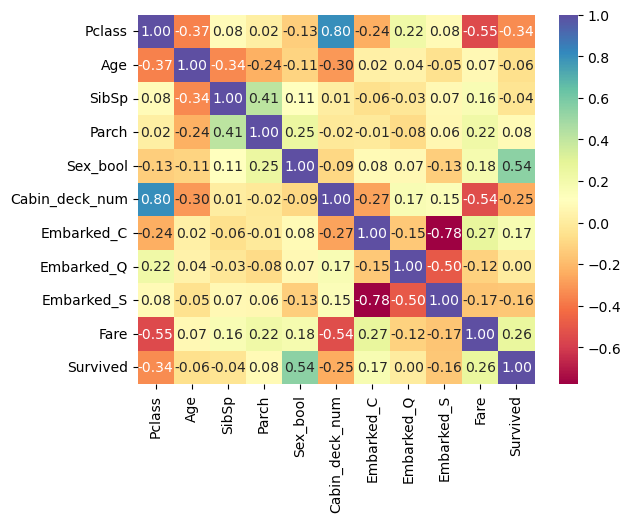

In [12]:
#We make our correlation matrix
corr = train_df.corr()
sns.heatmap(corr, annot=True,fmt=".2f", cmap="Spectral")

So based on this heatmap we can say that the feature that has the stronger relationship with the "Surivived" variable is "Sex_bool". Which enforces the hypothesis that if you were a women you had high chances at survival. 

The second best feature is "PClass", which also endorses our hypothesis 3 and 4 that based on your class you have more chances at survival. The next feature is the "cabin_deck_num", which by the way also has a strong relationship with "PClass" Variable. Which make sense, because depending on where you were sleeping influences on the timing you have to get out of the ship. 

In [13]:
#We eliminate the columns that are non-numerical
train_df=train_df.drop(['Name','Ticket','Cabin_deck'], axis=1)

#We divide our x_train_set and our y_train_set
x_train = train_df.iloc[:,1:10]
y_train = train_df.iloc[:,10:]

Now that we know that the "Sex_bool" column has a high relation with the "survival" column, we must validate our first hypothesis.

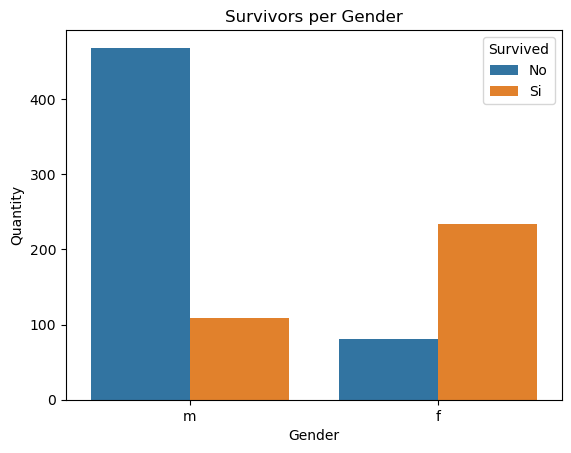

In [14]:
sns.countplot(data=train_df, x='Sex_bool', hue='Survived')
plt.title('Survivors per Gender')
plt.xlabel('Gender')
plt.ylabel('Quantity')
plt.xticks([0,1], ['m','f'])
plt.legend(title="Survived", labels=["No","Si"])
plt.show()

As we can see, we have validated our first hypothesis. And by seeing the heatmap we can also assure that eventhough you were not from first/second class, you'd still had a chance at surviving just because you were a women.

Now let's go and train our model. 

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, train_size=0.8, random_state=42)

#We construct our benchmark decision Tree.
clf = DecisionTreeClassifier(random_state=0)
clf.fit(x_train,y_train)

y_test_pred = clf.predict(x_test)
y_test_proba = clf.predict_proba(x_test)
print("Accuracy: ", accuracy_score(y_test, y_test_pred))
#print("ROC AUC: ", roc_auc_score(y_test, y_test_proba))
print("Classsification report:\n", classification_report(y_test, y_test_pred))

Accuracy:  0.7653631284916201
Classsification report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80       105
           1       0.71      0.73      0.72        74

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179



In general this model is pretty good detecting the ones that survived from the ones that don't, it actually has not much bias nor variance. It is slightly better detecting de female male samples than the female ones, but that is normal considering that we had more male samples than female. 

Let's try som Hyperparameter tuning to see if we can get a better accuracy for both of them. 

In [21]:
#define a parameter grid
param_grid = {'max_depth': [3,5],
              'min_samples_leaf':[4,6],
              'criterion':['gini']}

#Configure the grid search
grid_search = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          cv=5,
                          scoring='f1')

#Train the grid_search
grid_search.fit(x_train,y_train)

#Best hyperparameter
print("Best Hyperparameters:", grid_search.best_params_)

best_clf = grid_search.best_estimator_
y_test_pred = best_clf.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Classification report:\n", classification_report(y_test, y_test_pred))

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4}
Accuracy: 0.7877094972067039
Classification report:
               precision    recall  f1-score   support

           0       0.78      0.89      0.83       105
           1       0.80      0.65      0.72        74

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.77       179
weighted avg       0.79      0.79      0.78       179



If we see the accuracy, it has improved, but when we see the precision for the male class and the recall for the female class, the model is not generalizing well. In these two metrics, the model underperformed from the first model. In other words, the model is not that good classificating the true positives in the female class and it has also failed a bit in having more purity in the male class.  

Since the parameters that we have established failed on getting a more robust model, we can try to implement a RandomForest and see if we can get a better result.

In [ ]:
#Terminar analisis de si fue me
#Ejemplo con Random Forests,